In [3]:
import argparse
import os
from zipfile import ZipFile
from urllib.request import urlopen
import shutil
import pandas as pd
from time import time
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.optimizers import Adam
import csv
from tensorflow.keras.models import Model, load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import backend as K
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small, NASNetMobile, DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications.densenet import preprocess_input
from tensorflow.keras import Input
import matplotlib.pyplot as plt
import seaborn as sns

# Global paths
OUTPUT_DIRECTORY = "./outputs/"
LABEL_DIRECTORY = "/kaggle/input/deepweeds/labels/"
IMG_DIRECTORY = "/kaggle/input/deepweeds/images/"

# Global variables
RAW_IMG_SIZE = (256, 256)
IMG_SIZE = (224, 224)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
MAX_EPOCH = 20
BATCH_SIZE = 64
FOLDS = 1
STOPPING_PATIENCE = 4
LR_PATIENCE = 16
INITIAL_LR = 0.0001
CLASSES = [str(i) for i in range(9)]
CLASS_NAMES = ['Chinee Apple',
               'Lantana',
               'Parkinsonia',
               'Parthenium',
               'Prickly Acacia',
               'Rubber Vine',
               'Siam Weed',
               'Snake Weed',
               'Negative']

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
CLASS_NAMES

['Chinee Apple',
 'Lantana',
 'Parkinsonia',
 'Parthenium',
 'Prickly Acacia',
 'Rubber Vine',
 'Siam Weed',
 'Snake Weed',
 'Negative']

In [5]:
def crop(img, size):
    """
    Crop the image concentrically to the desired size.
    :param img: Input image
    :param size: Required crop image size
    :return:
    """
    (h, w, c) = img.shape
    x = int((w - size[0]) / 2)
    y = int((h - size[1]) / 2)
    return img[y:(y + size[1]), x:(x + size[0]), :]


def crop_generator(batches, size):
    """
    Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator
    :param batches: Batches of images to be cropped
    :param size: Size to be cropped to
    :return:
    """
    while True:
        batch_x, batch_y = next(batches)
        (b, h, w, c) = batch_x.shape
        batch_crops = np.zeros((b, size[0], size[1], c))
        for i in range(b):
            batch_crops[i] = crop(batch_x[i], (size[0], size[1]))
        yield (batch_crops, batch_y)

In [7]:
train_label_file = "{}train_subset{}.csv".format(LABEL_DIRECTORY, 0)
val_label_file = "{}val_subset{}.csv".format(LABEL_DIRECTORY, 0)
test_label_file = "{}test_subset{}.csv".format(LABEL_DIRECTORY, 0)
train_dataframe = pd.read_csv(train_label_file, dtype=str)
val_dataframe = pd.read_csv(val_label_file, dtype=str)
test_dataframe = pd.read_csv(test_label_file, dtype=str)
train_image_count = train_dataframe.shape[0]
val_image_count = val_dataframe.shape[0]
test_image_count = test_dataframe.shape[0]

In [8]:
print('Total Number of Training Images: {}'.format(train_image_count))
print('Total Number of Validation Images: {}'.format(val_image_count))
print('Total Number of Test Images: {}'.format(test_image_count))
print('Total Number of Classes of Weeds: {}'.format(9))

Total Number of Training Images: 10501
Total Number of Validation Images: 3501
Total Number of Test Images: 3507
Total Number of Classes of Weeds: 9


In [9]:
train_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    #rescale=1. / 255,
    fill_mode="constant",
    shear_range=0.2,
    zoom_range=(0.5, 1),
    horizontal_flip=True,
    rotation_range=360,
    channel_shift_range=25,
    brightness_range=(0.75, 1.25))

val_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input
    # rescale=1. / 255
)

test_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input
    #rescale=1. / 255
)

train_data_generator = train_data_generator.flow_from_dataframe(
    train_dataframe,
    IMG_DIRECTORY,
    y_col='Label',
    x_col='Filename',
    target_size=RAW_IMG_SIZE,
    batch_size=BATCH_SIZE,
    has_ext=True,
    classes=CLASSES,
    class_mode='categorical')

val_data_generator = val_data_generator.flow_from_dataframe(
    val_dataframe,
    IMG_DIRECTORY,
    y_col="Label",
    x_col="Filename",
    target_size=RAW_IMG_SIZE,
    batch_size=BATCH_SIZE,
    has_ext=True,
    shuffle=False,
    classes=CLASSES,
    class_mode='categorical')

test_data_generator = test_data_generator.flow_from_dataframe(
    test_dataframe,
    IMG_DIRECTORY,
    y_col="Label",
    x_col="Filename",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    has_ext=True,
    shuffle=False,
    classes=CLASSES,
    class_mode='categorical')

Found 10501 validated image filenames belonging to 9 classes.
Found 3501 validated image filenames belonging to 9 classes.
Found 3507 validated image filenames belonging to 9 classes.


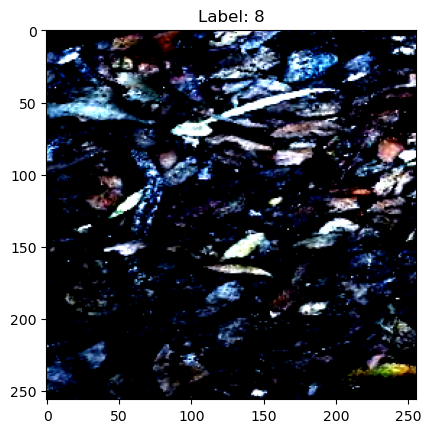

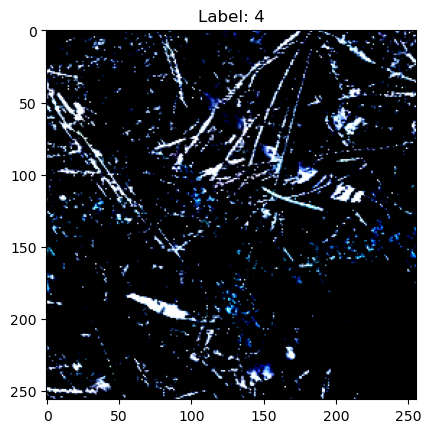

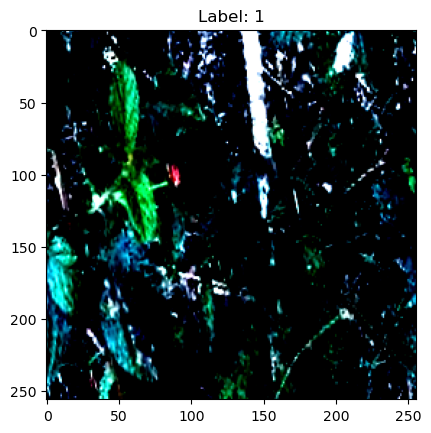

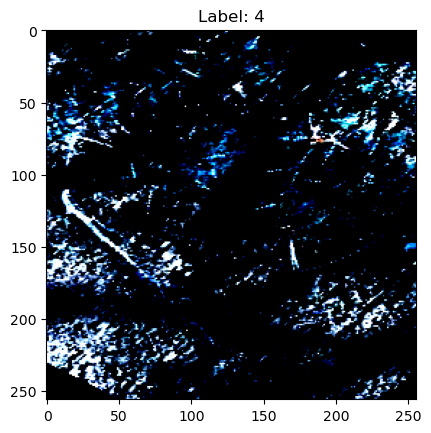

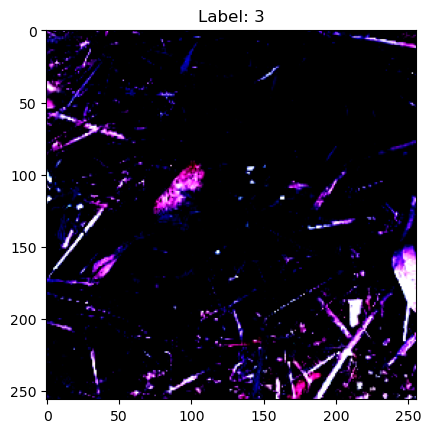

In [41]:
batch_images, batch_labels = next(train_data_generator)

for i in range(5):
    plt.imshow(batch_images[i])
    plt.title(f"Label: {np.argmax(batch_labels[i])}")
    plt.show()

In [11]:
!pip install  tensorflow_hub

In [12]:
base_model = DenseNet121(weights="imagenet", include_top=False, pooling='avg', input_shape=INPUT_SHAPE)

for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
x = Dense(256, activation='relu')(base_model.output)
x = Dense(128, activation='relu')(x)

x = Dropout(0.4)(x)

outputs = Dense(len(CLASSES), activation='softmax', name='fc9')(x)

model = Model(inputs=base_model.inputs, outputs=outputs)

timestamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')

print('Fold {}/{} - {}'.format(0 + 1, FOLDS, timestamp))

early_stopping = EarlyStopping(patience=STOPPING_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=LR_PATIENCE, min_lr=0.000003125)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=INITIAL_LR), 
              metrics=['categorical_accuracy'])

29084464/29084464 [==============================] - 2s 0us/step
Fold 1/1 - 20231228-160030


In [13]:
    train_data_generator.reset()
    val_data_generator.reset()

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [15]:
history = model.fit(
        train_data_generator,
        steps_per_epoch=train_image_count // BATCH_SIZE,
        epochs=10,
        validation_data=val_data_generator,
        validation_steps=val_image_count // BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr], shuffle=False)

Epoch 1/10
164/164 [==============================] - 339s 2s/step - loss: 1.5461 - categorical_accuracy: 0.5242 - val_loss: 1.2130 - val_categorical_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/10
164/164 [==============================] - 198s 1s/step - loss: 1.1311 - categorical_accuracy: 0.6142 - val_loss: 0.9274 - val_categorical_accuracy: 0.6921 - lr: 1.0000e-04
Epoch 3/10
164/164 [==============================] - 197s 1s/step - loss: 0.8969 - categorical_accuracy: 0.6988 - val_loss: 0.7851 - val_categorical_accuracy: 0.7248 - lr: 1.0000e-04
Epoch 4/10
164/164 [==============================] - 199s 1s/step - loss: 0.7711 - categorical_accuracy: 0.7370 - val_loss: 0.7136 - val_categorical_accuracy: 0.7488 - lr: 1.0000e-04
Epoch 5/10
164/164 [==============================] - 198s 1s/step - loss: 0.6770 - categorical_accuracy: 0.7702 - val_loss: 0.6799 - val_categorical_accuracy: 0.7642 - lr: 1.0000e-04
Epoch 6/10
164/164 [==============================] - 198s 1s/step - loss: 0.615

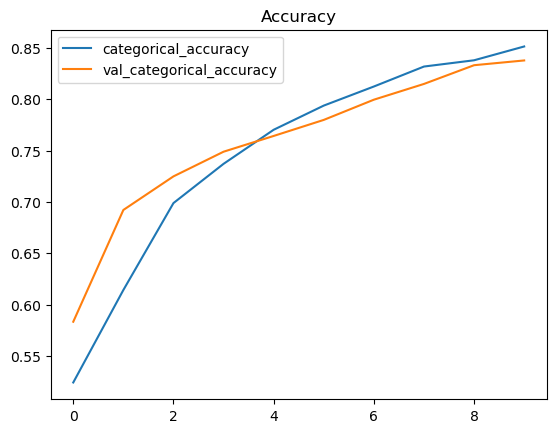

In [16]:
pd.DataFrame(history.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [18]:
import tensorflow_hub as hub

In [20]:
from tensorflow.keras import layers
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(224,224, 3))
feature_extractor.trainable = False
model1 = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(9, activation='softmax')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 9)                 11529     
                                                                 
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(RAW_IMG_SIZE[0], RAW_IMG_SIZE[1], 3))

for layer in base_model.layers:
    layer.trainable = False

model1 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation='softmax')  # Adjust the number of units based on your number of classes
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

history = model1.fit(
    train_data_generator,
    steps_per_epoch=len(train_data_generator),
    epochs=10, 
    validation_data=val_data_generator,
    validation_steps=len(val_data_generator)
)

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 9)                 2313      
                                                         

KeyboardInterrupt: 

In [ ]:
#Thus Densenet performed better than resnet

In [33]:
results = model.evaluate(test_data_generator)
print(f'test_loss: {results[0]} - test_categorical_accuracy: {results[1]*100}')

55/55 [==============================] - 42s 730ms/step - loss: 0.5274 - categorical_accuracy: 0.8224
test_loss: 0.5274491310119629 - test_categorical_accuracy: 82.23552703857422


In [35]:
test_data_generator.reset()
predictions = np.argmax(model.predict(test_data_generator), axis=1)

55/55 [==============================] - 13s 208ms/step


In [44]:
predictions

['0',
 '1',
 '8',
 '8',
 '4',
 '0',
 '0',
 '8',
 '0',
 '8',
 '8',
 '0',
 '0',
 '0',
 '0',
 '8',
 '8',
 '0',
 '1',
 '8',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '8',
 '8',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '8',
 '1',
 '8',
 '8',
 '8',
 '8',
 '0',
 '8',
 '8',
 '8',
 '1',
 '0',
 '1',
 '8',
 '8',
 '1',
 '8',
 '8',
 '1',
 '8',
 '8',
 '8',
 '8',
 '8',
 '1',
 '5',
 '0',
 '0',
 '7',
 '0',
 '7',
 '7',
 '7',
 '0',
 '0',
 '8',
 '0',
 '8',
 '7',
 '7',
 '8',
 '7',
 '7',
 '7',
 '7',
 '7',
 '7',
 '7',
 '7',
 '0',
 '7',
 '8',
 '0',
 '7',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '7',
 '7',
 '0',
 '7',
 '7',
 '7',
 '7',
 '7',
 '7',
 '0',
 '0',
 '0',
 '8',
 '0',
 '0',
 '0',
 '8',
 '7',
 '0',
 '7',
 '7',
 '8',
 '7',
 '0',
 '7',
 '0',
 '0',
 '8',
 '0',
 '0',
 '8',
 '0',
 '0',
 '0',
 '0',
 '0'

In [36]:
labels = dict((v, k) for k, v in test_data_generator.class_indices.items())
actual = list(test_dataframe.Label)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71       226
           1       0.81      0.76      0.78       213
           2       0.90      0.88      0.89       207
           3       0.95      0.40      0.56       205
           4       0.67      0.86      0.76       213
           5       0.91      0.66      0.76       202
           6       0.89      0.77      0.83       215
           7       0.86      0.56      0.68       204
           8       0.82      0.94      0.88      1822

    accuracy                           0.82      3507
   macro avg       0.84      0.72      0.76      3507
weighted avg       0.83      0.82      0.81      3507



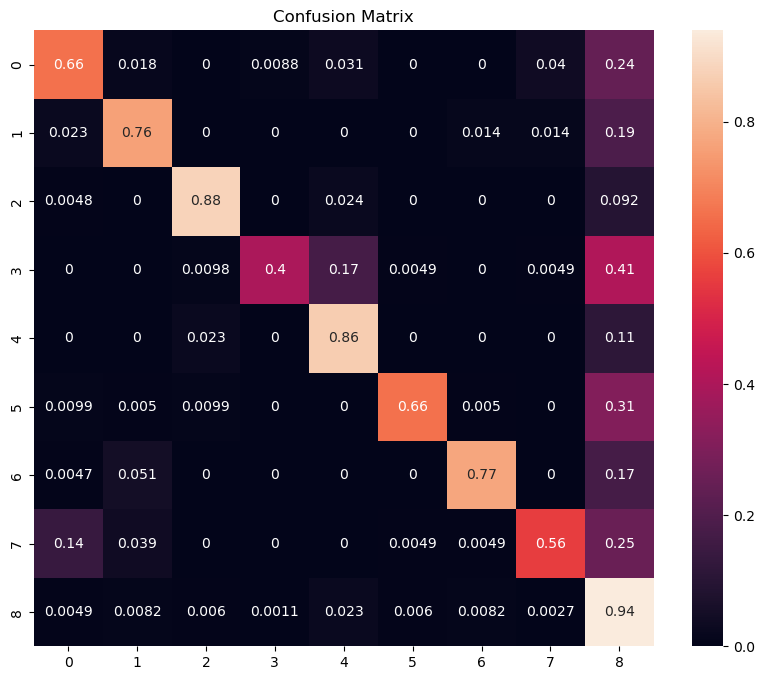

In [37]:
# Confusion matrix
cf = confusion_matrix(actual, predictions, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(actual)), yticklabels = sorted(set(actual)))
plt.title('Confusion Matrix')
plt.show()